# Load Tiny ImageNet

In [1]:
!git clone https://github.com/baiydaavi/vonenet.git
%cd vonenet/
!git checkout avi

Cloning into 'vonenet'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 179 (delta 10), reused 15 (delta 7), pack-reused 160
Receiving objects: 100% (179/179), 508.06 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Checking out files: 100% (26/26), done.
/content/vonenet
Already on 'avi'
Your branch is up to date with 'origin/avi'.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

from vonenet import VOneNet

In [ ]:
if not os.path.exists('/content/tiny-imagenet-200/'):
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -q tiny-imagenet-200.zip

batch_size = 128

id_dict = {}
for i, line in enumerate(open('tiny-imagenet-200/wnids.txt', 'r')):
  id_dict[line.replace('\n', '')] = i

--2021-08-14 17:39:33--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.68MB/s    in 22s     

2021-08-14 17:39:56 (10.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
class TrainTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("tiny-imagenet-200/train/*/*/*.JPEG")
        self.transform = transform
        self.id_dict = id

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.id_dict[img_path.split('/')[2]]
        if self.transform:
            image = self.transform(image)
        return image, label

class TestTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("tiny-imagenet-200/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id
        self.cls_dic = {}
        for i, line in enumerate(open('tiny-imagenet-200/val/val_annotations.txt', 'r')):
            a = line.split('\t')
            img, cls_id = a[0],a[1]
            self.cls_dic[img] = self.id_dict[cls_id]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.cls_dic[img_path.split('/')[-1]]
        if self.transform:
            image = self.transform(image)
        return image, label


transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.05, 0.05), scale=(1.0, 1.2)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = TrainTinyImageNetDataset(id=id_dict, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TestTinyImageNetDataset(id=id_dict, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

#Training ResNet-18

Source - https://github.com/kuangliu/pytorch-cifar

In [ ]:
#from vonenet import *

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [4]:
# Model
print('==> Building model..')
# net = models.resnet18()
net  = VOneNet(model_arch='resnet18', noise_mode=None, image_size=64, visual_degrees=2, sf_max=11.3, stride=4, ksize=25, k_exc=23.5)
net = net.to(device)

# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.pth')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

==> Building model..
Neuronal distributions gabor parameters


/content/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Model:  VOneResnet18


In [5]:
print(net)

Sequential(
  (vone_block): VOneBlock(
    (simple_conv_q0): GFB()
    (simple_conv_q1): GFB()
    (simple): ReLU(inplace=True)
    (complex): Identity()
    (gabors): Identity()
    (noise): Identity()
    (output): Identity()
  )
  (bottleneck): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (model): ResNetBackEnd(
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
criterion = nn.CrossEntropyLoss()
# replace 0.01 as argument for lr with args.lr if using argparse
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [ ]:
# Training
train_loss_vec = []
train_acc_vec = []
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader))
    print(f'Training Loss: {train_loss/(batch_idx+1)} | Training Acc: {100.*correct/total} ({correct}/{total})')
    train_loss_vec.append(train_loss/(batch_idx+1))
    train_acc_vec.append(100.*correct/total)

In [ ]:
# Testing
test_loss_vec = []
test_acc_vec = []
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        scheduler.step(test_loss)

        print(f'Validation Loss: {test_loss/(batch_idx+1)} | Validation Acc: {100.*correct/total} ({correct}/{total})')

    test_loss_vec.append(test_loss/(batch_idx+1))
    test_acc_vec.append(100.*correct/total)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/VoneResnet18_{epoch}.pth')
        best_acc = acc

In [ ]:
for epoch in range(start_epoch, start_epoch+80):
    train(epoch)
    test(epoch)


Epoch: 0
Training Loss: 4.536651938162801 | Training Acc: 7.363 (7363/100000)
Validation Loss: 4.167579653896863 | Validation Acc: 11.21 (1121/10000)
Saving..

Epoch: 1
Training Loss: 3.822089694040206 | Training Acc: 16.29 (16290/100000)
Validation Loss: 3.8212468835371958 | Validation Acc: 16.69 (1669/10000)
Saving..

Epoch: 2
Training Loss: 3.4851759568504663 | Training Acc: 21.794 (21794/100000)
Validation Loss: 3.461487045770959 | Validation Acc: 22.59 (2259/10000)
Saving..

Epoch: 3
Training Loss: 3.278750481203084 | Training Acc: 25.293 (25293/100000)
Validation Loss: 3.8802557534809354 | Validation Acc: 18.25 (1825/10000)

Epoch: 4
Training Loss: 3.147620045315579 | Training Acc: 27.636 (27636/100000)
Validation Loss: 3.284805165061468 | Validation Acc: 25.92 (2592/10000)
Saving..

Epoch: 5
Training Loss: 3.034390367510374 | Training Acc: 29.509 (29509/100000)
Validation Loss: 3.1818388504318045 | Validation Acc: 26.4 (2640/10000)
Saving..

Epoch: 6
Training Loss: 2.9496192249

In [ ]:
# Checking Best Accuracy
def check_accuracy():
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f'Loss: {test_loss/(batch_idx+1)} | Acc: {100.*correct/total} ({correct}/{total})')

check_accuracy()

Text(0.5, 0, 'epoch')

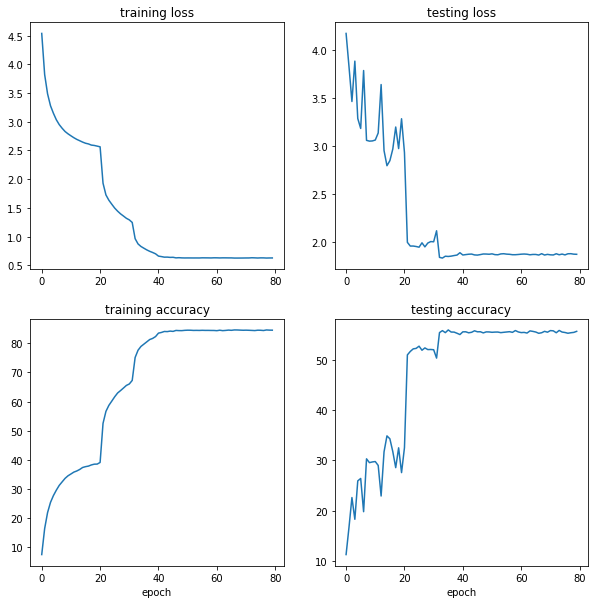

In [ ]:
# Training Plots

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('training loss')
plt.plot(train_loss_vec)
plt.subplot(2,2,2)
plt.title('testing loss')
plt.plot(test_loss_vec)
plt.subplot(2,2,3)
plt.title('training accuracy')
plt.plot(train_acc_vec)
plt.xlabel('epoch')
plt.subplot(2,2,4)
plt.title('testing accuracy')
plt.plot(test_acc_vec)
plt.xlabel('epoch')

In [ ]:
from google.colab import files
!zip -r /content/checkpoint.zip /content/vonenet/checkpoint/
files.download("/content/checkpoint.zip")

  adding: content/vonenet/checkpoint/ (stored 0%)
  adding: content/vonenet/checkpoint/VoneResnet18_5.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_24.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_1.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_4.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_25.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_7.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_13.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_14.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_33.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_0.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_22.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_23.pth (deflated 16%)
  adding: content/vonenet/checkpoint/VoneResnet18_2.pth (deflated 16%)
  adding: content/vo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>